In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Data Preparation
data = pd.read_csv('phishing_site_urls.csv')

# Remove duplicated records
data = data.drop_duplicates()

# Remove records with Null columns
data = data.dropna()

# Step 2: Convert 'Label' column to numeric using LabelEncoder
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])  # Encode 'bad' as 0 and 'good' as 1

# Step 3: Split the data into training and testing sets
X = data['URL']  # Textual data (URLs)
y = data['Label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize and train the Random Forest classifier
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust the number of features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

# Step 5: Make predictions on the test set
y_rf_pred = rf_classifier.predict(X_test_tfidf)

# Step 6: Initialize and train the SVM classifier with TF-IDF vectorization
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)

# Step 7: Make predictions on the test set using the SVM classifier
y_svm_pred = svm_classifier.predict(X_test_tfidf)

# Step 8: Combine predictions using an ensemble method (e.g., voting)
y_combined_pred = np.vstack((y_rf_pred, y_svm_pred)).T
y_combined_pred = np.argmax(y_combined_pred, axis=1)

# Step 9: Evaluate the ensemble classifier
ensemble_accuracy = accuracy_score(y_test, y_combined_pred)
print(f"Ensemble Classifier Accuracy: {ensemble_accuracy:.2f}")

# Step 10: Prepare data for CNN
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_seq_length = 128

tokenized_texts = [tokenizer(text, padding='max_length', truncation=True, max_length=max_seq_length, return_tensors='pt') for text in X_train]

X_train_bert = torch.cat([text['input_ids'] for text in tokenized_texts], dim=0)
y_train_bert = torch.tensor(y_train.values)

# Step 9: Evaluate the ensemble classifier
ensemble_accuracy = accuracy_score(y_test, y_combined_pred)
print(f"Ensemble Classifier Accuracy: {ensemble_accuracy:.2f}")

# Step 10: Prepare data for CNN
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_seq_length = 128

tokenized_texts = [tokenizer(text, padding='max_length', truncation=True, max_length=max_seq_length, return_tensors='pt') for text in X_train]

X_train_bert = torch.cat([text['input_ids'] for text in tokenized_texts], dim=0)
y_train_bert = torch.tensor(y_train.values)

# ... (Previous code for CNN training)


Ensemble Classifier Accuracy: 0.39
Ensemble Classifier Accuracy: 0.39


In [19]:
# Map 1 to 2 in y_test and y_svm_pred
y_test_mapped = np.where(y_test == 1, 2, y_test)
y_svm_pred_mapped = np.where(y_svm_pred == 1, 2, y_svm_pred)

# Step 11: Calculate evaluation metrics for Random Forest Classifier
rf_accuracy = accuracy_score(y_test, y_rf_pred)
rf_f1_score = f1_score(y_test_mapped, y_rf_pred, pos_label=2)  # Specify pos_label as 2
rf_conf_matrix = confusion_matrix(y_test, y_rf_pred)
rf_tp = rf_conf_matrix[1, 1]
rf_tn = rf_conf_matrix[0, 0]
rf_fp = rf_conf_matrix[0, 1]
rf_fn = rf_conf_matrix[1, 0]
rf_precision = rf_tp / (rf_tp + rf_fp)  # Precision
rf_recall = rf_tp / (rf_tp + rf_fn)  # Recall

# Step 12: Calculate evaluation metrics for SVM Classifier
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_f1_score = f1_score(y_test_mapped, y_svm_pred, pos_label=2)  # Specify pos_label as 2
svm_conf_matrix = confusion_matrix(y_test, y_svm_pred)
svm_tp = svm_conf_matrix[1, 1]
svm_tn = svm_conf_matrix[0, 0]
svm_fp = svm_conf_matrix[0, 1]
svm_fn = svm_conf_matrix[1, 0]
svm_precision = svm_tp / (svm_tp + svm_fp)  # Precision
svm_recall = svm_tp / (svm_tp + svm_fn)  # Recall


Random Forest Classifier Metrics:
Accuracy: 0.96
F1-Score: 0.96
Precision: 0.95
Recall: 0.98

SVM Classifier Metrics:
Accuracy: 0.96
F1-Score: 0.97
Precision: 0.96
Recall: 0.98


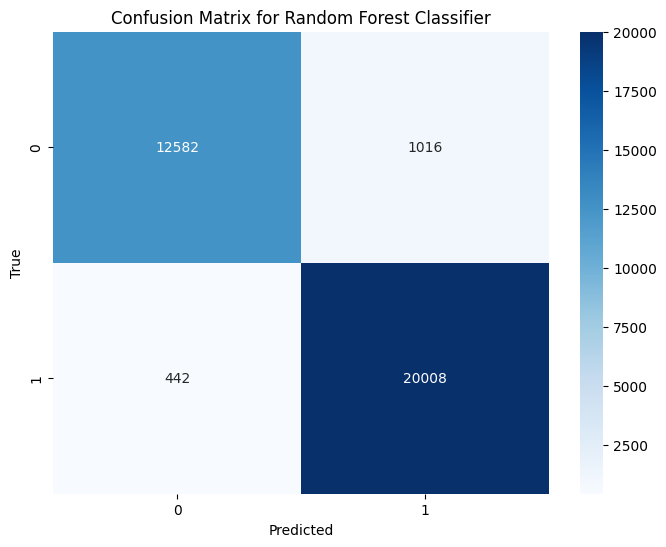

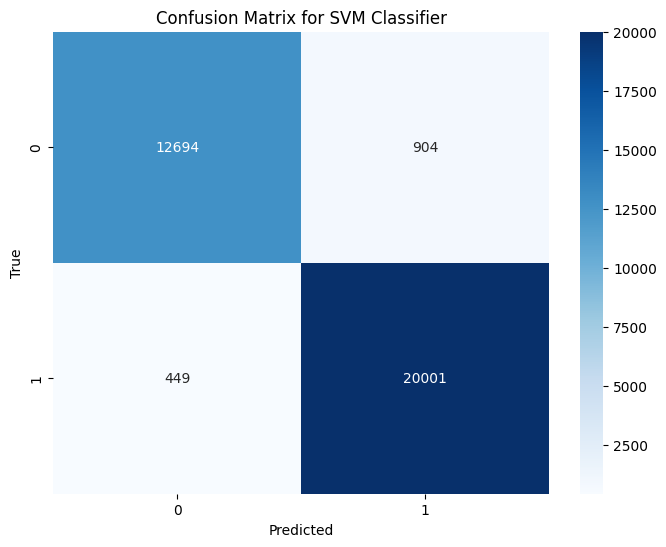

In [18]:
# Print and visualize evaluation metrics for Random Forest Classifier
print("Random Forest Classifier Metrics:")
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"F1-Score: {rf_f1_score:.2f}")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")

# Print and visualize evaluation metrics for SVM Classifier
print("\nSVM Classifier Metrics:")
print(f"Accuracy: {svm_accuracy:.2f}")
print(f"F1-Score: {svm_f1_score:.2f}")
print(f"Precision: {svm_precision:.2f}")
print(f"Recall: {svm_recall:.2f}")

# Visualize the confusion matrix for Random Forest Classifier
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

# Visualize the confusion matrix for SVM Classifier
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVM Classifier")
plt.show()


In [86]:
# ... (Previous code for data preprocessing, Random Forest, and SVM classifiers)

# Step 13: Prepare data for CNN
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_seq_length = 128

# Tokenize and prepare the test data as well
tokenized_texts_train = [tokenizer(text, padding='max_length', truncation=True, max_length=max_seq_length, return_tensors='pt') for text in X_train]
tokenized_texts_test = [tokenizer(text, padding='max_length', truncation=True, max_length=max_seq_length, return_tensors='pt') for text in X_test]

X_train_bert = torch.cat([text['input_ids'] for text in tokenized_texts_train], dim=0)
X_test_bert = torch.cat([text['input_ids'] for text in tokenized_texts_test], dim=0)

# Convert labels to tensors
y_train_bert = torch.tensor(y_train.values)
y_test_bert = torch.tensor(y_test.values)

# Define a DataLoader for training and testing data
batch_size = 32  # Adjust as needed
train_dataset = TensorDataset(X_train_bert, y_train_bert)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Continue with the definition of the CNN model as shown previously

# Step 14: Training loop for the CNN
cnn_model = CNNModel(in_channels=768, num_classes=num_classes)  # Assuming num_classes is defined correctly
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)  # Adjust the learning rate as needed
epochs = 5

cnn_model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Add an extra dimension for channels and sequence length
        inputs = inputs.unsqueeze(1)  # Shape: [batch_size, 1, sequence_length]

        # Ensure that inputs have the correct number of channels (768 for BERT embeddings)
        inputs = inputs.expand(-1, 768, -1)  # Shape: [batch_size, 768, sequence_length]

        # Cast inputs to FloatTensor
        inputs = inputs.float()

        outputs = cnn_model(inputs)
        labels = labels.squeeze()  # Remove potential extra dimensions
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Evaluate the CNN model on the test data
cnn_model.eval()
with torch.no_grad():
    inputs = X_test_bert.unsqueeze(1).expand(-1, 768, -1).float()
    outputs = cnn_model(inputs)
    _, predicted = torch.max(outputs, 1)
    cnn_accuracy = accuracy_score(y_test_bert, predicted.numpy())

print(f"CNN Model Accuracy: {cnn_accuracy:.2f}")


Epoch 1/5, Loss: 313019.3422
Epoch 2/5, Loss: 166689.8545
Epoch 3/5, Loss: 146642.3474
Epoch 4/5, Loss: 164994.0960
Epoch 5/5, Loss: 115314.7765
CNN Model Accuracy: 0.62


CNN Model Accuracy: 0.62
CNN Model Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.06      0.11     13598
     Class 1       0.61      1.00      0.76     20450

    accuracy                           0.62     34048
   macro avg       0.80      0.53      0.43     34048
weighted avg       0.77      0.62      0.50     34048



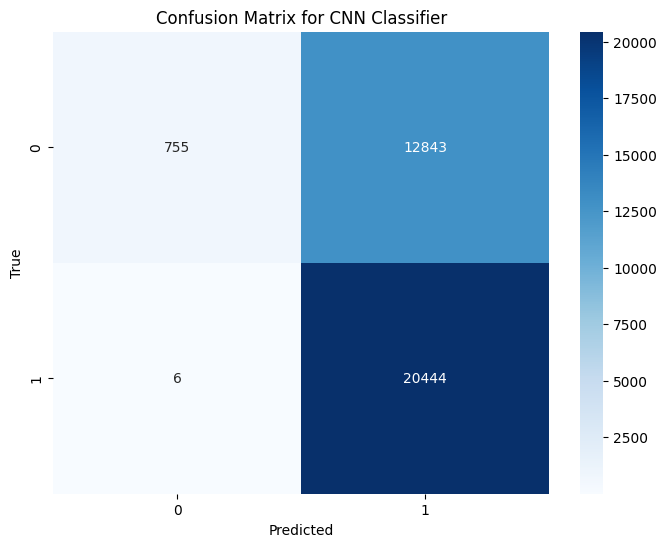

In [87]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the CNN model on the test data
cnn_model.eval()
with torch.no_grad():
    inputs = X_test_bert.unsqueeze(1).expand(-1, 768, -1).float()
    outputs = cnn_model(inputs)
    _, predicted = torch.max(outputs, 1)
    cnn_accuracy = accuracy_score(y_test_bert, predicted.numpy())
    cnn_conf_matrix = confusion_matrix(y_test_bert, predicted.numpy())

print(f"CNN Model Accuracy: {cnn_accuracy:.2f}")

# Print the classification report (includes precision, recall, F1-score, and more)
print("CNN Model Classification Report:")
print(classification_report(y_test_bert, predicted.numpy(), target_names=["Class 0", "Class 1"]))

# Visualize the confusion matrix for CNN Classifier
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for CNN Classifier")
plt.show()
